___
## <font color="#CA3532"> Cuantificacion Caso 1 </font>

##### <font color="#CA7868"> Abrán Yuen, Versión 1 </font>

___

##### <font color="#CA3532"> Paquetes necesarios

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns # Necesario para plotear
import matplotlib.pyplot as plt # Necesario para plotear multiplot line
import os # Necesario para rutas

import time # Tiempo de ejecución
from datetime import timedelta # Tiempo ejecucion en hh:mm:ss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

from quantificationlib.base import UsingClassifiers
from quantificationlib.baselines.ac import AC
from quantificationlib.multiclass.em import EM
from quantificationlib.multiclass.df import HDy, HDX
from quantificationlib.multiclass.energy import EDX ,EDy
from quantificationlib.decomposition.multiclass import OneVsRestQuantifier
from quantificationlib.metrics.multiclass import mean_absolute_error
from quantificationlib.bag_generator import PriorShift_BagGenerator

import warnings
warnings.filterwarnings("ignore")

##### <font color="#CA3532"> Construccion de funciones de interés

In [3]:
from sklearn.utils.validation import check_array, check_consistent_length
def check_prevalences(p_true, p_pred):
    """ Check that p_true and p_pred are valid and consistent

        Parameters
        ----------
        p_true : array_like, shape = (n_classes)
            True prevalences

        p_pred : array_like, shape = (n_classes)
            Predicted prevalences

        Returns
        -------
        p_true : array-like of shape = (n_classes, 1)
            The converted and validated p_true array

        p_pred : array-like of shape = (n_classes, 1)
            The converted and validated p_pred array
    """
    check_consistent_length(p_true, p_pred)
    p_true = check_array(p_true, ensure_2d=False)
    p_pred = check_array(p_pred, ensure_2d=False)

    if p_true.ndim == 1:
        p_true = p_true.reshape((-1, 1))

    if p_pred.ndim == 1:
        p_pred = p_pred.reshape((-1, 1))

    if p_true.shape[1] != p_pred.shape[1]:
        raise ValueError("p_true and p_pred have different length")

    return p_true, p_pred
def prueba(p_true, p_pred):
    """ Mean absolute error

            :math:`mae = 1/l \sum_{j=1}^{j=l} | p_j - \hat{p}_j |`

        being l the number of classes

        Parameters
        ----------
        p_true : array_like, shape = (n_classes)
            True prevalences

        p_pred : array_like, shape = (n_classes)
            Predicted prevalences

        Returns
        -------
        MAE : float
            It is equal to :math:`1/l \sum_{j=1}^{j=l} | p_j - \hat{p}_j |`
    """
    p_true, p_pred = check_prevalences(p_true, p_pred)
    
    return np.abs(p_pred)

# Función de preprocesado para tablon filtrado
def prepro(df):
    # Seleccionamos solo las variables necesarias
    # ========================================================================
    df_filtrado=df.loc[:,['nmethod','ntrain','mean_Error']]  

    # Agrupamos por media
    # ========================================================================
    df_filt_group=df_filtrado.groupby(by=["nmethod","ntrain"]).mean() 
    #reseteamos index
    # ========================================================================
    df_filt_group.reset_index(inplace=True) 
    # ========================================================================
    res = df_filt_group.pivot(index='ntrain', columns=('nmethod'), values='mean_Error')
    # Debido a que tenemos multi-index, volvemos a resetear el index
    # ========================================================================
    res=res.reset_index() 
    # Debido al indice generado por la operación group by la unica forma de asignar un nuevo index es creando una nueva tabla 
    # ========================================================================
    lst=res.loc[:,['ntrain']].values #Generamos lista para df
    df = pd.DataFrame(lst)
    #df.index = list(df["ntrain"])
    df_filtrado_recons = pd.merge(df, res, left_index=True, right_index=True) #
    df_filtrado_recons = df_filtrado_recons.iloc[:,1:]
    df_filtrado_recons.rename(columns = {'HDx':'HDX','OVR-HDx':'OVR-HDX'}, inplace = True)
    df_filtrado_recons=df_filtrado_recons.set_index('ntrain')
    return df_filtrado_recons

# Funcion para ver la distribucion min y max de probabilidades
def distribucion(df):

    sns.set(style="ticks")
    df=df
    fig, axs = plt.subplots(2, 2, figsize=(20, 5))

    sns.kdeplot(df['P_REAL_class_1'], shade=True,color="pink", ax=axs[0,0] )
    sns.kdeplot(df['P_REAL_class_2'], shade=True,color="plum", ax=axs[0,1]).set_title('Clase 2')
    sns.kdeplot(df['P_REAL_class_3'], shade=True,color="darkmagenta", ax=axs[1,0]).set_title('Clase 3')
    sns.kdeplot(df['P_REAL_class_4'], shade=True,color="midnightblue", ax=axs[1,1]).set_title('Clase 4')
    plt.show()

    # Mostramos rango de valores en cada clase para filtrar
    # ==========================================================
    descrip=df.describe().loc[['min','max'],['P_REAL_class_1','P_REAL_class_2','P_REAL_class_3','P_REAL_class_4']]
    return descrip


##### <font color="#CA3532"> Construccion de cuantificación 

In [4]:
# 1) Función para generar valores artificiales
# ========================================================================
def datos(m11,m12,m21,m22,m31,m32,m41,m42,cova11,cova12,cova21,cova22,n_puntos,title):
    
    # n_puntos: Número de puntos por categoría
    
    # Centroides 
    # ======================
    mu1 = [m11, m12]
    mu2 = [m22, m22]
    mu3 = [m31, m32]
    mu4 = [m41, m42]

    # Dispersion de puntos Covarianzas
    # ======================
    cov1 = [[cova11, cova12],
           [cova21, cova22]]
    cov2 = cov1
    cov3 = cov1
    cov4 = cov1

    # Generacion aleatoria de puntos según el centroide y dispersión
    # Puntos generados con distribución Multivariante
    # Generación de clases
    # ======================
    seed=123
    rng=np.random.RandomState(seed)
    factor_X= np.vstack(( 
                         rng.multivariate_normal(mu1, cov1, n_puntos),
                         rng.multivariate_normal(mu2, cov2, n_puntos),
                         rng.multivariate_normal(mu3, cov3, n_puntos),
                         rng.multivariate_normal(mu4, cov4, n_puntos)))


    factor_Y = np.hstack((np.ones(n_puntos, dtype=int),
                        np.ones(n_puntos, dtype=int) * 2,
                        np.ones(n_puntos, dtype=int) * 3,
                        np.ones(n_puntos, dtype=int) * 4)) 

    # Generacion de DataFrame con dos variables y Factor Clase con 4 clases
    # ======================
    df= pd.DataFrame(factor_X, columns = ['X1','X2'])
    df['Clase'] = factor_Y

    g=sns.pairplot(  vars=["X1","X2"], data=df, hue="Clase")
    g.fig.suptitle(title, y=1.08)
    
# 2) Función para cuantificar según dístintos métodos
# ========================================================================    
def cuanti(m11,m12,m21,m22,m31,m32,m41,m42,cova11,cova12,cova21,cova22,est_name,ntrain,ntest,nreps ,nbags,title):
    seed=123
    rng = np.random.RandomState(seed)

    # Dataset 2D
    mu1 = [m11, m12]
    mu2 = [m21, m22]
    mu3 = [m31, m32]
    mu4 = [m41, m42]

    cov1 = [[cova11, cova12],
           [cova21, cova22]]
    cov2 = cov1
    cov3 = cov1
    cov4 = cov1


    #   methods
    # Multivariantes
    ac = AC(distance='L2')
    em = EM()
    hdy = HDy(n_bins=8)
    hdx = HDX(n_bins=8)
    edx = EDX()
    edy = EDy()

    # One vs Res
    ovr_ac = OneVsRestQuantifier(base_quantifier=AC())
    ovr_em = OneVsRestQuantifier(base_quantifier=EM())
    ovr_hdy = OneVsRestQuantifier(base_quantifier=HDy(n_bins=8))
    ovr_hdx = OneVsRestQuantifier(base_quantifier=HDX(n_bins=8))
    ovr_edx = OneVsRestQuantifier(base_quantifier=EDX())
    ovr_edy = OneVsRestQuantifier(base_quantifier=EDy())

    methods = [ac, em, hdy, hdx, edx,  edy,ovr_ac, ovr_em, ovr_hdy, ovr_hdx, ovr_edx,ovr_edy]
    methods_names = ['AC','EM','HDy','HDx','EDX','EDy','OVR-AC','OVR-EM','OVR-HDy','OVR-HDx','OVR-EDX','OVR-EDy']
                     
    #   to store all the quant_results
    quant_results = np.zeros((len(methods_names), len(ntrain)))
    print('')
    print('Total bags', nbags)
    print('Total repeticiones', nreps)
    print('Tamaño test', ntest)
    print('Total train', ntrain)
    print('estimador',est_name)
    print('')
    
    #---------
    #--------- Nuevo
    #--------- 
    df_proba = pd.DataFrame([])
    df_proba2 = pd.DataFrame([])
    df_proba3 = pd.DataFrame([])
    #---------
    #--------- Fin de Nuevo
    #--------- 
    
    for k in range(len(ntrain)):

        all_quant_results = np.zeros((len(methods_names), nreps * nbags))

        print('\n#Training examples ', ntrain[k], 'Rep#', end=' ')

        for rep in range(nreps):

            print(rep+1, end=' ', flush=True)

            x_train = np.vstack((rng.multivariate_normal(mu1, cov1, ntrain[k]),
                                 rng.multivariate_normal(mu2, cov2, ntrain[k]),
                                 rng.multivariate_normal(mu3, cov3, ntrain[k]),
                                 rng.multivariate_normal(mu4, cov4, ntrain[k])))

            y_train = np.hstack((np.ones(ntrain[k], dtype=int),
                                 np.ones(ntrain[k], dtype=int) * 2,
                                 np.ones(ntrain[k], dtype=int) * 3,
                                 np.ones(ntrain[k], dtype=int) * 4))

            #  binary estimator
            if est_name == 'CalRF':
                estimator = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, random_state=seed,
                                                                          class_weight='balanced'))
                
            
            elif est_name == 'RF':
                estimator = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
            elif est_name == 'LR':
                estimator = LogisticRegression(C=1, random_state=seed, max_iter=10000, solver='liblinear')

            #  one vs rest estimator
            ovr_estimator = OneVsRestClassifier(estimator, n_jobs=-1)

            estimator.fit(x_train, y_train)
            predictions_train = estimator.predict_proba(x_train)

            ovr_estimator.fit(x_train, y_train)
            ovr_predictions_train = ovr_estimator.predict_proba(x_train)

            for nmethod, method in enumerate(methods):
                if isinstance(method, UsingClassifiers):
                    if isinstance(method, OneVsRestQuantifier):
                        method.fit(X=x_train, y=y_train, predictions_train=ovr_predictions_train)
                    else:
                        method.fit(X=x_train, y=y_train, predictions_train=predictions_train)
                else:
                    method.fit(X=x_train, y=y_train)

            x_test = np.vstack((rng.multivariate_normal(mu1, cov1, ntest),
                                rng.multivariate_normal(mu2, cov2, ntest),
                                rng.multivariate_normal(mu3, cov3, ntest),
                                rng.multivariate_normal(mu4, cov4, ntest)))

            y_test = np.hstack((np.ones(ntest, dtype=int),
                                np.ones(ntest, dtype=int) * 2,
                                np.ones(ntest, dtype=int) * 3,
                                np.ones(ntest, dtype=int) * 4))

            predictions_test = estimator.predict_proba(x_test)
            ovr_predictions_test = ovr_estimator.predict_proba(x_test)

            #  Testing bags
            bag_generator = PriorShift_BagGenerator(n_bags=nbags, bag_size=ntest,
                                                    min_prevalence=None, random_state=seed + rep + 10)
                                                    #min_prevalence=[0.4,0,0,0.3], random_state=seed + rep + 10)

            prev_true, indexes = bag_generator.generate_bags(x_test, y_test)

            for n_bag in range(nbags):

                for nmethod, method in enumerate(methods):
                    if isinstance(method, UsingClassifiers):
                        if isinstance(method, OneVsRestQuantifier):
                            if isinstance(method.base_quantifier, UsingClassifiers):
                                p_predicted = method.predict(X=None,
                                                             predictions_test=ovr_predictions_test[indexes[:, n_bag], :])
                            else:
                                p_predicted = method.predict(X=x_test[indexes[:, n_bag], :])
                        else:
                            p_predicted = method.predict(X=None,
                                                         predictions_test=predictions_test[indexes[:, n_bag], :])
                    else:
                        p_predicted = method.predict(X=x_test[indexes[:, n_bag], :])
                    
                    #---------
                    #--------- Nuevo
                    #--------- 
                    # Tabla con propensiones
                    # Construcción de DF con las probabilidades por clase
                    # ===========================================================================
                    all_quant_results2=prueba(prev_true[:, n_bag],p_predicted).T
                    data = pd.DataFrame(all_quant_results2)
                    #data['Coordenadas']=x_test[indexes[:, n_bag], :]
                    data['method']=method
                    data['nmethod']=nmethod
                    data['nbags'] = nbags
                    data['nreps'] = nreps
                    data['Est_name'] = est_name
                    data['ntrain'] = ntrain[k]
                    #data['x_test']= X
                    #data['x_test']= x_test
                    data.rename(columns = {0:'Prob_class_1', 1:'Prob_class_2',2:'Prob_class_3',3:'Prob_class_4'}, inplace = True)
                    df_proba = df_proba.append(data)  
                    df_proba['nmethod'] = df_proba['nmethod'].replace([0,1,2,3,4,5,6,7,8,9,10,11],['AC','EM','HDy','HDx','EDX','EDy','OVR-AC','OVR-EM','OVR-HDy','OVR-HDx','OVR-EDX','OVR-EDy'])
                    #df_proba['nmethod'] = df_proba['nmethod'].replace([0,1,2,3,4,5,6,7,8,9],['AC','EM','HDy','HDx','EDX','OVR-AC','OVR-EM','OVR-HDy','OVR-HDx','OVR-EDX'])
                    #print(df_proba.head())
                    # Fin de tabla con propensiones
                    # ===========================================================================

                    # ===========================================================================
                    all_quant_results_est=pd.DataFrame(prev_true[:, n_bag]).T #propensiones estimadas
                    df_est=pd.DataFrame(all_quant_results_est)
                    df_proba2 = df_proba2.append(df_est) 


                    all_quant_results_real=pd.DataFrame(p_predicted).T   # propensiones reales
                    df_real=pd.DataFrame(all_quant_results_real)
                    df_proba3 = df_proba3.append(df_real) 
                    #---------
                    #--------- Fin de Nuevo
                    #---------
                    
                    all_quant_results[nmethod, rep * nbags + n_bag] = mean_absolute_error(prev_true[:, n_bag],
                                                                                          p_predicted)

                    quant_results[nmethod, k] = quant_results[nmethod, k] + \
                                                all_quant_results[nmethod, rep * nbags + n_bag]
    #---------
    #--------- Nuevo
    #---------
    df_proba2.rename(columns = {0:'P_REAL_class_1', 1:'P_REAL_class_2',2:'P_REAL_class_3',3:'P_REAL_class_4'}, inplace = True)
    df_proba3.rename(columns = {0:'P_EST_class_1', 1:'P_EST_class_2',2:'P_EST_class_3',3:'P_EST_class_4'}, inplace = True)
    df_proba_real= pd.concat([df_proba2, df_proba3], axis=1)
    df_proba_real= pd.concat([df_proba, df_proba_real], axis=1)
    df_proba_real= df_proba_real.iloc[:,5:]
    #---------
    #--------- Fin de Nuevo
    #---------
    quant_results = quant_results / (nreps * nbags) # Se normaliza la salida, ya que los clasificadores son independientes. Es una forma de asegurar que todo suma 1
    # Unimos todos los métodos por tamaño de train
    df=pd.merge(pd.DataFrame(methods_names, columns=['n_train']), 
                pd.DataFrame(quant_results, columns=ntrain), 
             left_index=True, right_index=True)

    df_t = df.transpose()
    df_t.columns = df_t.iloc[0]
    df_t=df_t[1:]
    df_t['Est_name'] = est_name
    df_t['Dispersion'] = cova11
    
    df_t['ntest'] = ntest
    df_t['nreps'] = nreps
    df_t['nbags'] = nbags

    
    
    #name_file = '/Users/abran.yuen/TFM_OVR/'+title + '-avg-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
    name_file = title + '-avg-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
                '-ntest' + str(ntest) + '.txt'
    file_avg = open(name_file, 'w')
    file_avg.write('#examples, ')
    for index, m in enumerate(methods_names):
        file_avg.write('%s, ' % m)
    for index, number in enumerate(ntrain):
        file_avg.write('\n%d, ' % number)
        for i in quant_results[:, index]:
            file_avg.write('%.5f, ' % i)

    file_avg.close()
    
    # Inicio proceso para guardar tabla propensiones
    df_proba_real=df_proba_real.reset_index()
    #df_proba_real.to_csv('/Users/abran.yuen/TFM_OVR/'+title + '-Prob-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
    df_proba_real.to_csv(title + '-Prob-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
                '-ntest' + str(ntest) + '.csv') 
    
    
    # Eliminamos el caso EM
    df_t=df_t.drop(['EM', 'OVR-EM'], axis=1)
    df_proba_real =df_proba_real.loc[(df_proba_real['nmethod']!='EM') & (df_proba_real['nmethod']!='OVR-EM') ]
    
    return df_t , df_proba_real

# 3) Comparativa gráfica de MAE por método y tamaño de train
# ========================================================================    
def comp_line(df):
    #fig = plt.figure(figsize=(18,3))
    fig = plt.figure(figsize=(18,3))
    ax1 = plt.subplot(151)
    ax2 = plt.subplot(152)
    ax3 = plt.subplot(153)
    ax4 = plt.subplot(154)
    ax5 = plt.subplot(155)
    df.plot(y=['AC','OVR-AC'],ax=ax1)
    df.plot(y=['HDx','OVR-HDx'],ax=ax2)
    df.plot(y=['HDy','OVR-HDy'],ax=ax3)
    df.plot(y=['EDX','OVR-EDX'],ax=ax4)
    df.plot(y=['EDy','OVR-EDy'],ax=ax5)
    plt.tight_layout()
    return plt.show()

### <font color="#CA3532"> 1. Experimentación
### <font color="#CA3532"> 1.1 Estado inicial


Total bags 50
Total repeticiones 10
Tamaño test 2000
Total train [50, 100, 200, 500, 1000, 1500]
estimador RF


#Training examples  50 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  100 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  200 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  500 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  1000 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  1500 Rep# 1 2 3 4 5 6 7 8 9 10 

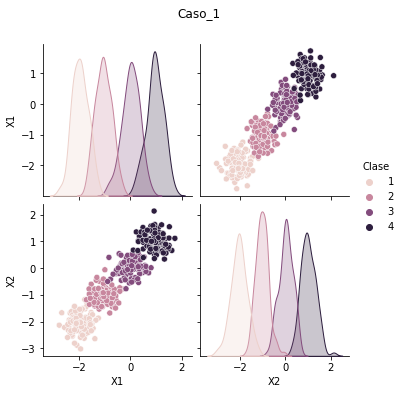

<Figure size 1296x216 with 0 Axes>

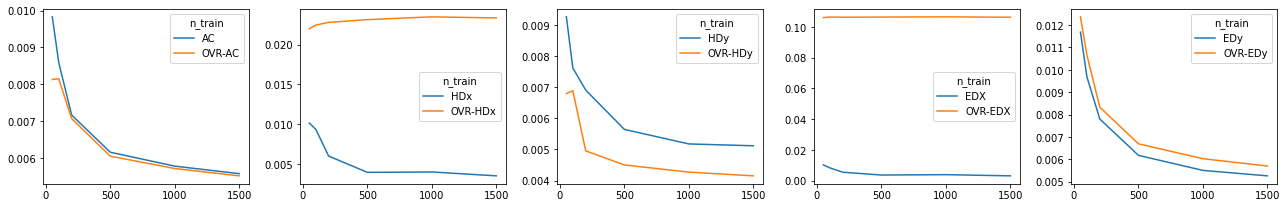

--- 0:31:32.918202 TIME ---


In [6]:
# Caso 1
start_time = time.time()
# Datos
# ========================================================================    
datos(m11=-2,m12=-2,
                   m21=-1,m22=-1,
                   m31=0,m32=0,
                   m41=1,m42=1,
                   cova11=0.1,cova12=0,
                   cova21=0,cova22=0.1, 
                   n_puntos=100,title='Caso_1')


# Cuantificación
# ========================================================================    
df_caso1=cuanti(m11=-2,m12=-2,
                   m21=-1,m22=-1,
                   m31=0,m32=0,
                   m41=1,m42=1,
                   cova11=0.1,cova12=0,
                   cova21=0,cova22=0.1, 
                   est_name='RF',ntrain=[50,100,200,500,1000,1500],ntest=2000,nreps=10 ,nbags=50,title='Caso_1')

# Comparativa gráfica de MAE por método y tamaño de train
# ========================================================================    
comp_line(df_caso1[0])

elapsed = (time.time() - start_time)

print("--- %s TIME ---" % str(timedelta(seconds=elapsed)))


Total bags 50
Total repeticiones 10
Tamaño test 1000
Total train [50, 100, 200, 500, 1000, 1500]
estimador LR


#Training examples  50 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  100 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  200 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  500 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  1000 Rep# 1 2 3 4 5 6 7 8 9 10 
#Training examples  1500 Rep# 1 2 3 4 5 6 7 8 9 10 

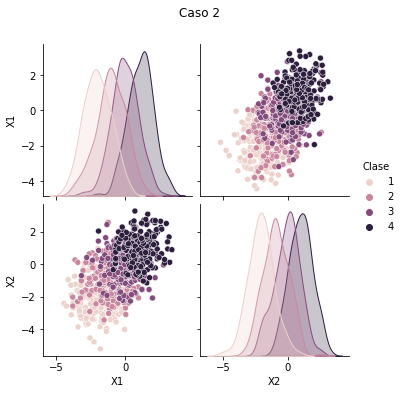

<Figure size 1296x216 with 0 Axes>

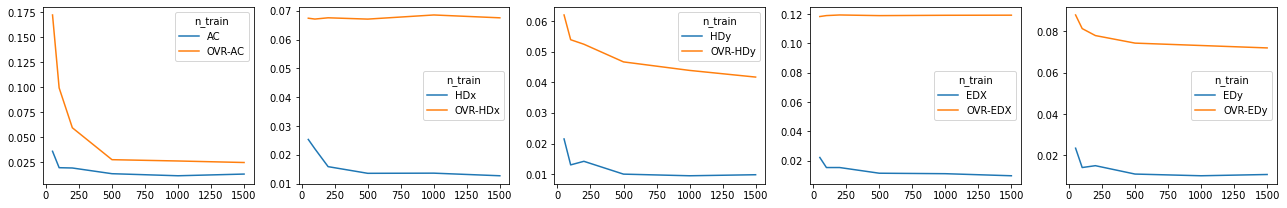

--- 0:29:21.370823 TIME ---


In [16]:
# Caso 2
start_time = time.time()
# Datos
# =======================================================================    
datos(m11=-2,m12=-2,
                   m21=-1,m22=-1,
                   m31=0,m32=0,
                   m41=1,m42=1,
                   cova11=1,cova12=0,
                   cova21=0,cova22=1, n_puntos=200, title='Caso 2')

# Cuantificación
# ========================================================================    
df_caso2=cuanti(m11=-2,m12=-2,
                   m21=-1,m22=-1,
                   m31=0,m32=0,
                   m41=1,m42=1,
                   cova11=0.3,cova12=0,
                   cova21=0,cova22=0.3, 
                   est_name='LR',ntrain=[50,100,200,500,1000,1500],ntest=1000,nreps=10 ,nbags=50, title='Caso_2')
                   

# Comparativa gráfica de MAE por método y tamaño de train
# ========================================================================    
comp_line(df_caso2[0])

elapsed = (time.time() - start_time)

print("--- %s TIME ---" % str(timedelta(seconds=elapsed)))